In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape,LeakyReLU, Dropout
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D,UpSampling2D
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ab = np.load('/content/drive/My Drive/ab1.npy')
gray = np.load('/content/drive/My Drive/gray_scale.npy')

In [ ]:
# preps grayscale images
def batch_prep(gray_img, batch_size=100):
  #creates an array of zeros that a CNN accepts (batch size, height, width, depth (3 channels for RGB))
  img = np.zeros((batch_size, 224, 224, 3))
  # takes only the batch size of gray images and iterates through 3 channels (RGB) then appends to empty img array
  for i in range(0,3):
    img[:batch_size,:,:,i] = gray_img[:batch_size]
    return img
img_in = batch_prep(gray, batch_size=300)

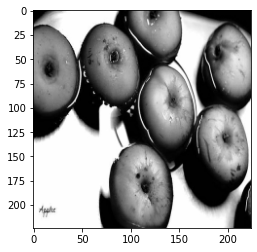

In [ ]:
# displays gray images
plt.imshow(gray[29], cmap=plt.cm.gray)

In [ ]:
# displays original data channels (batch size, height, width)
gray.shape

(25000, 224, 224)

In [ ]:
# displays data channels post prep (batch size, height, width, depth (RGB))
img_in.shape

(300, 224, 224, 3)

In [ ]:
# CNN model learns from grayscale and colored images

# preps colored images
# n represents batch size
def get_rbg(gray_imgs, ab_imgs, n=10):
  img1 = np.zeros((n, 224, 224, 3))
  # 0 and 1 denotes where we want to allocate the images
  img1[:,:,:,0] = gray_imgs[0:n:]
  img1[:,:,:,1:] = ab_imgs[0:n]
  # converts images to uint8 format to make it easier for cv2 library to process
  img1 = img1.astype("uint8")
  imgs = []
  for i in range(0, n):
    # converts images from LAB to RGB colorspace
    imgs.append(cv2.cvtColor(img1[i], cv2.COLOR_LAB2RGB))
  # converts images to numPy array
  imgs = np.array(imgs)
  return imgs

In [ ]:
img_out = get_rbg(gray_imgs=gray, ab_imgs=ab, n=300)

In [ ]:
# Conv2d helps to convert data into tensors
# strides indicates the number of pixels that are shifted 
# kernel_size is a matrix that performs a dot product with the sub region of the data in order to extract RGB features from the image, hence why we use 3
# filters are a set of learnable weights that use the back propagation algorithm to learn these weights and are dependent on kernel size (must be in multiples of 3)
# bias is an additional set of weights that allow you to shift the activation function by adding a constant which helps model select best possible weights on its own
# padding set to valid indicates all the images are the same size, therefore, we don't need padding
# relu (rectified linear unit) transforms the summed weighted input from the node into the activation of the node
# Conv2dTranspose is an inverse Conv2d layer that upsamples inputs and fine tunes the weights
# LeakyReLU activation function fixes the ReLU problem by adding a small gradient when the unit is not active
# Dropout layer prevents the model from overfitting

model = Sequential()
model.add(Conv2D(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1, kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1, kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

# AveragePooling2D calculates the average for each patch of the feature map of the images in our input. Summarizes weights and ensures the best possible outputs at the cost of downsampling the inputs
# UpSampling2d layer doubles the dimensions of our input and helps to counter the downsampling from AveragePooling2D

model.add(Conv2D(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1, kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(UpSampling2D((2, 2)))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=1, kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1, kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

In [ ]:
# Adam optimizer is an adaptive learning rate algorithm used for optimization
# mape (mean absolute percentage error) measures the extent of the error in the form of a percentage and is ideal for regression problem
# clipvalue clips the derivatives of the loss function and prevents gradient explosion (increased loss from each epoch) from occuring as you increase the amount of epochs

# compiles the model for training
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5), loss='mape', metrics=tf.keras.metrics.Accuracy())

In [ ]:
# batch_size should always be 16 for CNN models

# trains the model
model.fit(img_in, img_out, epochs=100, batch_size=16)

Epoch 1/100
19/19 [==============================] - 9s 66ms/step - loss: 13734592.3500 - accuracy: 0.0472
Epoch 2/100
19/19 [==============================] - 1s 55ms/step - loss: 3651.3697 - accuracy: 0.0637
Epoch 3/100
19/19 [==============================] - 1s 56ms/step - loss: 95.1788 - accuracy: 0.0625
Epoch 4/100
19/19 [==============================] - 1s 55ms/step - loss: 92.0850 - accuracy: 0.0792
Epoch 5/100
19/19 [==============================] - 1s 56ms/step - loss: 92.9627 - accuracy: 0.0704
Epoch 6/100
19/19 [==============================] - 1s 55ms/step - loss: 93.1664 - accuracy: 0.0683
Epoch 7/100
19/19 [==============================] - 1s 55ms/step - loss: 92.3717 - accuracy: 0.0763
Epoch 8/100
19/19 [==============================] - 1s 55ms/step - loss: 92.4891 - accuracy: 0.0751
Epoch 9/100
19/19 [==============================] - 1s 55ms/step - loss: 92.1322 - accuracy: 0.0787
Epoch 10/100
19/19 [==============================] - 1s 56ms/step - loss: 94.6052 

In [ ]:
# uses trained model to make a prediction on our grayscale images
prediction = model.predict(img_in)

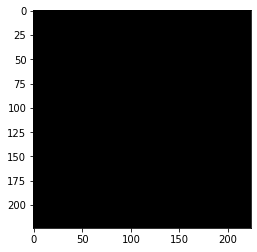

In [ ]:
# displays the prediction for the selected image in our input
plt.imshow(prediction[29])

In [ ]:
# saves current model
model.save('model.h5')

In [ ]:
# loads model file trained for 5000 epochs
model2 = keras.models.load_model('modelfinal.h5')

In [ ]:
prediction = model2.predict(img_in)

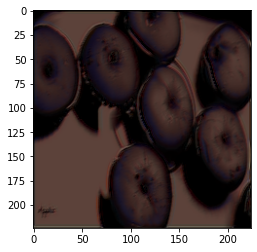

In [ ]:
# uint8 prevents issues with updated version of matplotlib
plt.imshow(prediction[29].astype('uint8'))